In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [4]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'
import numpy as np
import xarray as xr

sys.path.append('..')
%aimport project

In [12]:
case = project.imaging.Emory4DCTCase(data_root='../data/Emory-4DCT', case_name='Case1Pack', phases=[0, 50])
case.load_niftis()
case.load_masks(roi=['lung_combined_mask', 'body'])
case

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/body.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/body.nii.gz


Emory4DCTCase('../data/Emory-4DCT', 'Case1Pack', 2 phases)

In [23]:
case.mask.isel(z=slice(None,None,-1)).rolling(z=94, min_periods=1).max()

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


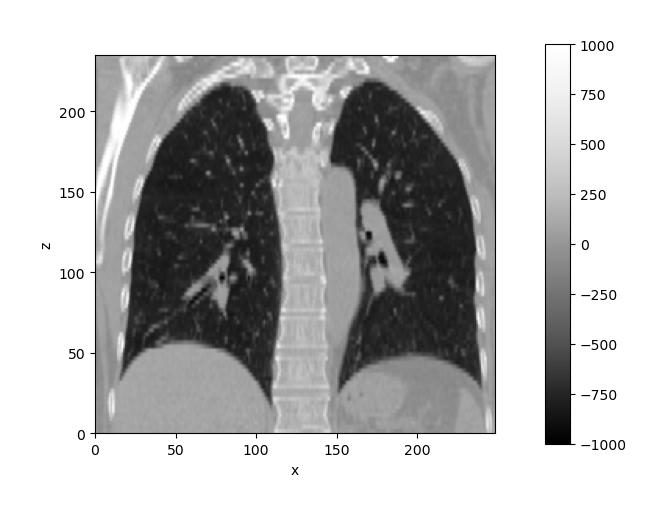

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (50, 1)), value=0), SelectionSlide…

<IPython.core.display.Javascript object>


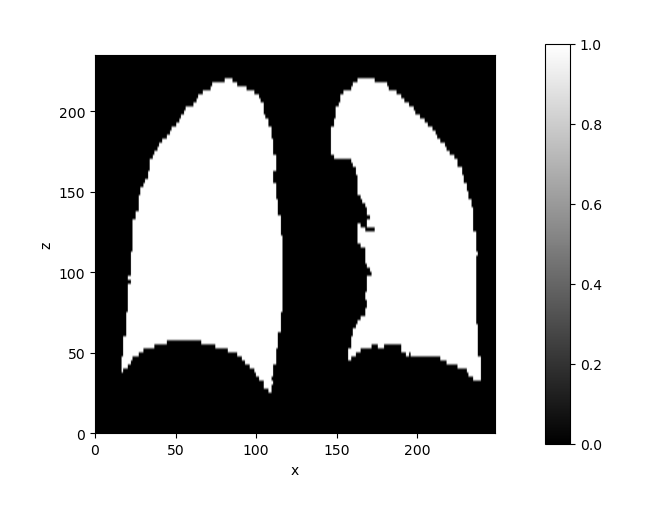

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (50, 1)), value=0), SelectionSlide…

In [24]:
%autoreload
project.visual.XArrayViewer(case.array, x='x', y='z', cmap='Greys_r', vmin=-1000, vmax=1000)
project.visual.XArrayViewer(case.mask,  x='x', y='z')

In [90]:
lung_mask.shape

(256, 256, 94)

In [99]:
lung_mask = case.mask.sel(roi='lung_combined_mask')

In [94]:
z_mask = lung_mask.max(['x', 'y'])
z_min = z_mask.argmax('z')
z_max = (94 - z_mask.reindex(z=lung_mask.z[::-1]).argmax('z'))
z_range = z_max - z_min

<IPython.core.display.Javascript object>


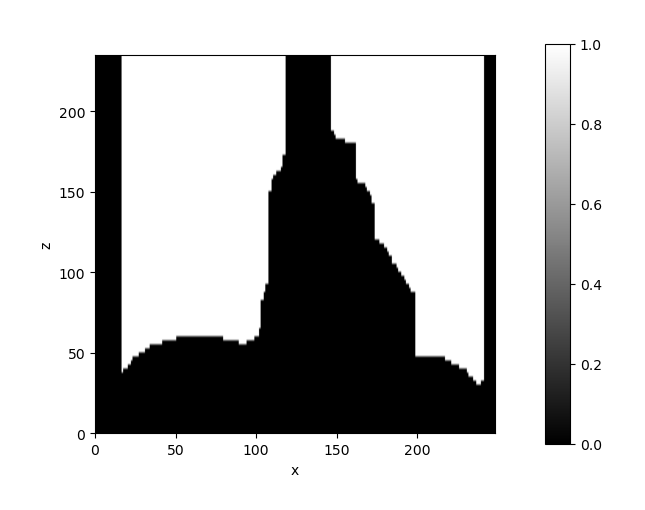

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (50, 1)), value=0), SelectionSlide…

In [93]:
upcasted_mask = lung_mask.rolling(z=94, min_periods=1).max()

project.visual.XArrayViewer(upcasted_mask, x='x', y='z')

<IPython.core.display.Javascript object>


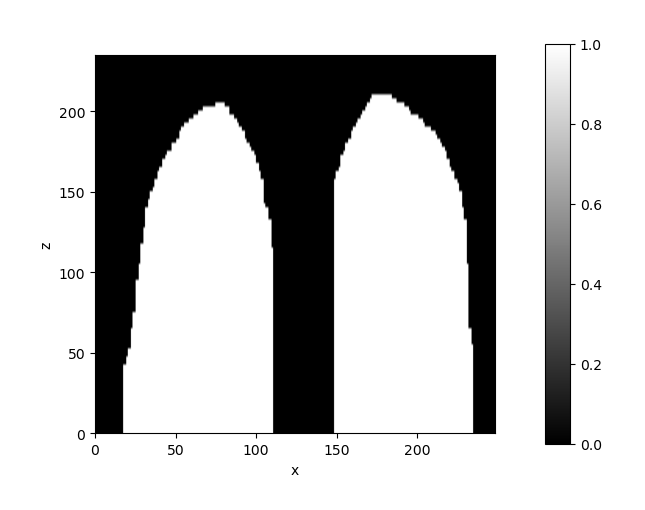

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (50, 1)), value=0), SelectionSlide…

In [73]:
downcasted_mask = lung_mask.reindex(z=lung_mask.z[::-1])
downcasted_mask = downcasted_mask.rolling(z=94, min_periods=1).max()
downcasted_mask = downcasted_mask.reindex(z=lung_mask.z)

project.visual.XArrayViewer(downcasted_mask, x='x', y='z')

<IPython.core.display.Javascript object>


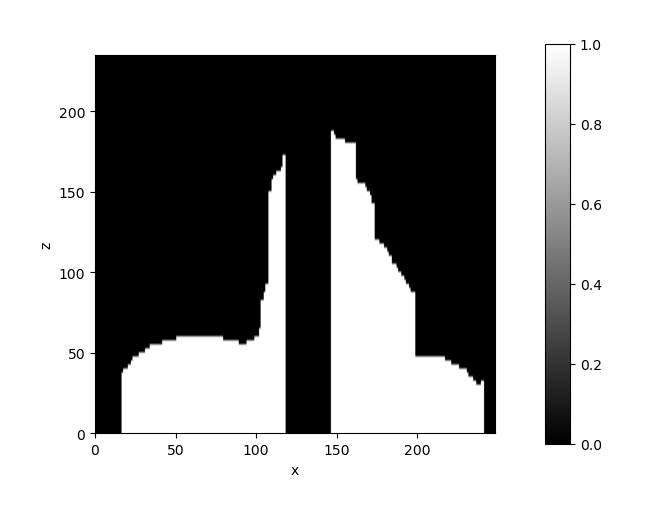

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (50, 1)), value=0), SelectionSlide…

In [74]:
height_mask = downcasted_mask - downcasted_mask * upcasted_mask

project.visual.XArrayViewer(height_mask, x='x', y='z')

In [113]:
def compute_diaphragm_mask(lung_mask, max_height=1/3):
    n_phase, n_x, n_y, n_z = lung_mask.shape
    
    output_mask = lung_mask.copy()

    for i, phase_mask in enumerate(lung_mask): # iterate over phase
        z_mask = phase_mask.max(['x', 'y']).values
        lung_bottom = z_mask.argmax()
        lung_top = n_z - z_mask[::-1].argmax()
        lung_range = lung_top - lung_bottom
        
        diaphragm_top = lung_bottom + int(max_height * lung_range)
        lower_portion_mask = phase_mask.copy()
        lower_portion_mask[...,diaphragm_top:] = 0
        
        above_mask = lower_portion_mask.copy()
        above_mask = above_mask.rolling(z=n_z, min_periods=1).max()
        
        below_mask = lower_portion_mask.reindex(z=phase_mask.z[::-1])
        below_mask = below_mask.rolling(z=n_z, min_periods=1).max()
        below_mask = below_mask.reindex(z=phase_mask.z)
        
        downcast_mask = below_mask * (1 - above_mask)

        output_mask[i,...] = downcast_mask
        
    return output_mask
        
compute_diaphragm_mask(lung_mask)

<xarray.DataArray 'mask' (phase: 2, x: 256, y: 256, z: 94)> Size: 99MB
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
...
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * phase    (phase) int64 16B 0 50
  * x        (x) float64 2kB 0.0 0.97 1.94 2.91 3.88 ... 244.4 245.4 246.4 247.4
  * y        (y) float64 2kB 0.0 0.97 1.94 2.91 3.88 ... 244.4 245.4 246.4 247.4
  * z        (z) float64 752B 0.0 2.5 5.0 7.5 10.0 ... 225.0 227.5 230.0 232.5
    roi      <U18 72B 'lung_combined_mask'

<IPython.core.display.Javascript object>


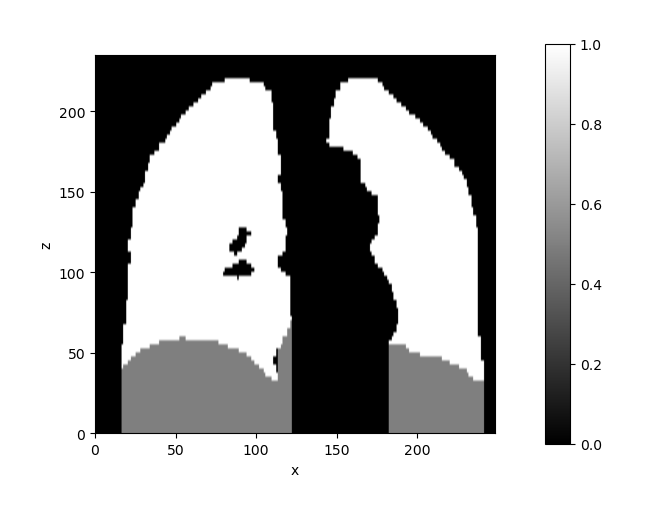

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (50, 1)), value=0), SelectionSlide…

In [116]:
diaph_mask = compute_diaphragm_mask(lung_mask)

project.visual.XArrayViewer(lung_mask + diaph_mask/2, x='x', y='z')